In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import interpolate

In [2]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data Ser...

In [3]:
import numpy as np
import xarray as xr
from scipy import interpolate

def compute_iso(data, iso, lev, d_or_t):

    """ compute the depth of some isopycnal/isotherm.
    
    Parameters:
    ----------------
    
    data: the input variable (Temperature, Density),
        array_like (3D), shape (N, M, L).
    iso: the objective isosurface layer,
        float.
    lev: the vertical depth,
        array_like (1D), shape (N).
    d_or_t: input d or t for density or temperature (lowercase)
        string
        
    Returns:
    ----------------
    
    var_iso: the output variable,
        array_like (2D), shape (M, L).
        
    """
    size = data.shape
    L = size[2]
    M = size[1]
    N = size[0] #this should be the same length as lev
    
    #check that the input data is in the for depth lat lon (or depth lon lat)
    if len(lev) != N:
        print('Error: either data input variable does not have depth as dimension 0, or lev variable is not same length as depth')
    else:
        if d_or_t in {'d', 't'}:
            var_iso = np.zeros((M, L)) # define the output var
            var_iso[:, :] = np.nan # NaN fill to avoid any later computation errors with zeros

            for i in np.arange(L): #loop through dimension 1
                for j in np.arange(M): #loop through dimension 2

                    data_prof = data[:, j, i] #select one profile
                    if d_or_t == 'd':
                        id1 = np.where(data_prof < iso)
                        if np.size(id1) > 0 and np.size(id1) < len(z):
                            var1 = data_prof[id1[0][-1]]
                            var2 = data_prof[id1[0][-1] + 1]
                            if var1 < var2:
                                func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                                var_iso[j, i] = func(iso)

                    else:
                        id1 = np.where(data_prof > iso)

                        if np.size(id1) > 0 and np.size(id1) < len(z):

                            var1 = data_prof[id1[0][-1]]
                            var2 = data_prof[id1[0][-1] + 1]

                            if var1 > var2:
                                func = interpolate.interp1d([var1, var2], [lev[id1[0][-1]], lev[id1[0][-1] + 1]])
                                var_iso[j, i] = func(iso)

        else:
            print('Is this density or temperature?')
    return var_iso

In [ ]:
%%time

pden = ds.ptemp #.chunk(chunks={'lat' : 30, 'lon' : 30})
z = pden.lev.values
iso = [15]

#for t in np.arange(size[0]):
for t in np.arange(1):
    data = pden[0, :, :].values
    dep_iso = compute_iso(data, iso, z, 't')
    #print(str(pden.time[t].values))
    
#ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])


In [ ]:
plt.contourf(dep_iso, np.arange(0, 400, 10))

In [6]:
def compute_isoval(density_data, ts_data, iso):

    """ compute temperature or salinity along some isopycnal/isotherm.
    
    Parameters:
    ----------------
    
    density_data: density input,
        array_like (3D), shape (N, M, L).
    ts_data: temp or salt input,
        array_like (3D), shape (N, M, L).
    iso: the objective isosurface layer,
        float.
        
    Returns:
    ----------------
    
    ts_iso: the output variable,
        array_like (2D), shape (M, L).
        
    """
    size = density_data.shape
    L = size[2]
    M = size[1]
    N = size[0]
    
    ts_iso = np.zeros((M, L)) # define the output var
    ts_iso[:, :] = np.nan # NaN fill to avoid any later computation errors with zeros
    
    dens = xr.DataArray(density_data)
    var = xr.DataArray(ts_data)
    a = dens.where(dens.min(axis=0)<iso)
    b = var.where(dens.min(axis=0)<iso) 

    for j in range(M):
        for k in range(L):
            x = a[:,j,k]
            y = b[:,j,k]
            f = interpolate.interp1d(x.values,y.values,'linear')
            ts_iso[j,k] = f(iso)
            
    return ts_iso

In [9]:
%%time

pden = ds.pden #.chunk(chunks={'lat' : 30, 'lon' : 30})
salt = ds.salt

iso = [27]

#for t in np.arange(size[0]):
for t in np.arange(1):
    density_data = pden[0, :, :].values
    ts_data = salt[0,:,:].values
    dep_iso = compute_isoval(density_data, ts_data, iso)
    #print(str(pden.time[t].values))

CPU times: user 32.2 s, sys: 149 ms, total: 32.3 s
Wall time: 38.6 s


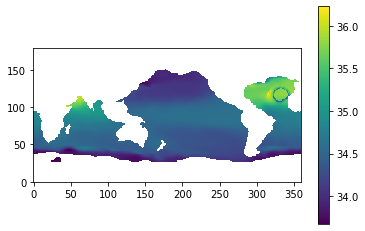

In [11]:
plt.imshow(dep_iso)
plt.colorbar()
plt.gca().invert_yaxis()


In [ ]:
#data = pden[0, :, :].values
np.where(data.min(axis=1)<iso)

In [ ]:
pden = ds.pden #.chunk(chunks={'lat' : 30, 'lon' : 30})
z = pden.lev.values

In [ ]:
salt = ds.salt

In [ ]:
data.min(axis=1)

In [ ]:
plt.imshow(data[0,:,:].min(axis=1))

In [ ]:
density_data.min(axis=0)

In [ ]:
density_data.where(density_data(axis = 0)>24)